In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

# General science/numeric tools
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# NLTK for NLP tools such as stemming, lemmatizing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer

import gensim
from tqdm.notebook import tqdm



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# to access my drive to read the csv-files
from google.colab import drive
drive.mount('/content/drive')

# link to the folder of Colab Notebooks 
%cd '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:
df = pd.read_csv('train_bodies.csv')
df1 = pd.read_csv('train_stances.csv')

df_merge = pd.merge(df, df1, on='Body ID')

TEXT_C = ['articleBody','Headline']
TARGET_C = 'Stance'

df_merge['Stance'].replace(['agree', 'disagree', 'discuss'], 'related',inplace=True)
print(df_merge['Stance'].value_counts())
# print(train_text.isna().sum())

unrelated    36545
related      13427
Name: Stance, dtype: int64


In [4]:
#drop Body ID 
df_merge.drop("Body ID", axis=1, inplace=True)

# Split data into train and temporary sets with an 80:20 split ratio
train, test = train_test_split(df_merge, test_size=0.4, random_state=42)

# Split the temporary set into validation and test sets with a 50:50 split ratio
val, test = train_test_split(test, test_size=0.5, random_state=42)


In [5]:
# Extract the text data and target data for each set
train_text, train_target = train[TEXT_C], train[TARGET_C]
val_text, val_target = val[TEXT_C], val[TARGET_C]
test_text, test_target = test[TEXT_C], test[TARGET_C]

In [6]:
# train_text = train_text[['articleBody', 'Headline']].applymap(preprocess)
# val_text = val_text[['articleBody', 'Headline']].applymap(preprocess)
# test_text = test_text[['articleBody', 'Headline']].applymap(preprocess)
# print(train_text.head())
# print(train_target.head())


In [7]:
print('Size of training set:',train.shape)
print('Size of validation set:',val.shape)
print('Size of validation set:',test.shape)
print(type(train_target))

Size of training set: (29983, 3)
Size of validation set: (9994, 3)
Size of validation set: (9995, 3)
<class 'pandas.core.series.Series'>


In [8]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a preprocessing function
def preprocess(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # Convert tokens back to text
    text = ' '.join(tokens)
    return text

In [9]:
# train_data = train_text
# train_data
# change the dataframe with two columns to a column to be used in tfidf function
combined_train_series = (train_text['articleBody']+train_text['Headline']).apply(preprocess)
combined_val_series = (val_text['articleBody']+val_text['Headline']).apply(preprocess)
combined_test_series = (test_text['articleBody']+test_text['Headline']).apply(preprocess)


In [10]:
# Convert the text data to numerical data

# Use TF-IDF to convert the text data to feature vectors
tfidf_vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)
# can set up max_df=0.8/0.9 to avoid the intervention of the most common words
train_features = tfidf_vectorizer.fit_transform(combined_train_series.values.astype('U'))
val_features = tfidf_vectorizer.transform(combined_val_series.values.astype('U'))
test_features = tfidf_vectorizer.transform(combined_test_series.values.astype('U'))

In [11]:
print('Size of training set:',train_features.shape)
print('Size of validation set:',val_features.shape)
print('Size of validation set:',test_features.shape)

Size of training set: (29983, 29614)
Size of validation set: (9994, 29614)
Size of validation set: (9995, 29614)


In [12]:
train_target

14020    unrelated
12430    unrelated
44352    unrelated
36868    unrelated
30213    unrelated
           ...    
11284    unrelated
44732      related
38158    unrelated
860      unrelated
15795    unrelated
Name: Stance, Length: 29983, dtype: object

In [13]:
# Convert the target data to numerical values
train_target = train_target.replace({'unrelated': 0, 'related': 1})
val_target = val_target.replace({'unrelated': 0, 'related': 1})
test_target = test_target.replace({'unrelated': 0, 'related': 1})

train = train.replace({'unrelated': 0, 'related': 1})
val = val.replace({'unrelated': 0, 'related': 1})
test = test.replace({'unrelated': 0, 'related': 1})

#build a new target-series data for BERT-model
train_target_bert = train_target
val_target_bert = val_target
test_target_bert = test_target

train_text_bert = train_text
val_text_bert = val_text
test_text_bert = test_text

In [14]:
test_text_bert.shape

(9995, 2)

In [15]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00


In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token, eos_token, pad_token, unk_token)


[CLS] [SEP] [PAD] [UNK]


In [18]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [19]:
import torch
import random
from torchtext import datasets
from torchtext.data.functional import to_map_style_dataset

train_dataset  = to_map_style_dataset(train.values)
# y_train_dataset = to_map_style_dataset(y_train_2)
val_dataset  = to_map_style_dataset(val.values)
# y_val_dataset = to_map_style_dataset(y_val_2)
test_dataset   = to_map_style_dataset(test.values)
# y_test_dataset = to_map_style_dataset(y_test_2)

train_dataset = list(train_dataset)
val_dataset = list(val_dataset)
test_dataset = list(test_dataset)

In [20]:
from torch.utils.data import DataLoader,Sampler
from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 32


# integrate headline and articlebody in this step
def vectorize_batch(batch):
    '''Take a batch of (text,label) pairs and return tensors ready for input to the model.'''
    label_list, text_list = [], []
    # train_dataset_c[0]['Headline'][0]    
    for (headline, body,stance) in batch:

    # for item in batch:
    #   headline, body, stance, *_ = item  # unpack only the first 3 values of the tuple
      new_column_values = []
      # Use a for loop to iterate over each row in the dataframe
      # for i in range (len(X_train_bert)):
        # Add the new string to the new_column_values list
      label_list.append(int(stance)-1)
      tokens = tokenizer.convert_tokens_to_ids(tokenize_and_cut(headline))
      tokens1 = tokenizer.convert_tokens_to_ids(tokenize_and_cut(body))
      text_list.append(torch.tensor([init_token_idx] + tokens + [eos_token_idx]+tokens1))
      # print(text_list)
    return pad_sequence(text_list,
                        padding_value=pad_token_idx,
                        batch_first=True), torch.tensor(label_list)
                                      
class BucketSampler(Sampler):
    def __init__(self, dataset, batch_size):
        # train_list = list(dataset)
        indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        random.shuffle(indices)
        self.batch_size = batch_size
        
        # create pool of indices with similar lengths 
        self.pooled_indices = []
        for i in range(0, len(indices), self.batch_size * 100):
            self.pooled_indices.extend(sorted(indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in self.pooled_indices]
        
    def __iter__(self):
        self.count = 0
        return self
    
    def __next__(self):
        # yield indices for current batch
        if self.count >= len(self.pooled_indices)-self.batch_size:
            raise StopIteration
        self.count += 1
        
        for i in range(0, len(self.pooled_indices), self.batch_size):
            return self.pooled_indices[self.count:self.count + self.batch_size]
        
    def __len__(self):
        return len(self.pooled_indices)


train_iterator  = DataLoader(train_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
val_iterator  = DataLoader(val_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
test_iterator   = DataLoader(test_dataset,  collate_fn=vectorize_batch, batch_size=BATCH_SIZE)

In [21]:
# num_epochs = 10  # define the number of epochs
# for epoch in range(num_epochs):
#     # training code here
#     for batch_idx, (train_text, train_target) in enumerate(train_iterator):
#       print("input_ids:",train_text)
#       print("labels:", train_target)
#       break
# train_dataset[0]

In [22]:
# DataLoader(train_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
# print(len(train_iterator))
# train_dataset


In [25]:
# type(train_target)
# train_target = train_target.values
# train_target.values
# print(type(train_text))
# print(type(train_target))
# print(len(a))
# len(b)


In [95]:
# train_text_bert, b = [], []
# for train_text,train_target in train_iterator:
#   a.append(train_text)
#   b.append(train_target)

    # print(len(train_target))
    # print("input_ids:",train_text)
    # print("labels:", train_target)

# # define preprocessing function
# def preprocess(text):
#     text = text.lower()
#     text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
#     return text

# # apply preprocessing to train_text_bert
# train_text_bert.apply_(preprocess)




In [42]:
a1 = []
b1 = []

for train_text_bert, train_target_bert in train_iterator:
    a1.append(train_text_bert)
    b1.append(train_target_bert)
    # print("input_ids:",train_text_berts)
    # print("labels:", train_target_bert)
    # break

In [77]:
for train_text_bert, train_target_bert in train_iterator:
    print("input_ids:",train_text_bert)
    print("labels:", train_target_bert)
    break

input_ids: tensor([[  101,  2414,  1010,  ...,     0,     0,     0],
        [  101,  9733,  1012,  ...,     0,     0,     0],
        [  101,  2167,  4759,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  3003,  ...,     0,     0,     0],
        [  101,  1996,  2796,  ...,     0,     0,     0],
        [  101, 15335,  1517,  ...,     0,     0,     0]])
labels: tensor([-1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1,
         0, -1,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1])


In [78]:
for val_text_bert, val_target_bert in val_iterator:
    print("input_ids:",val_text_bert)
    print("labels:", val_target_bert)
    break

input_ids: tensor([[  101, 10208, 19935,  ...,  3088,  1999,  2230],
        [  101,  1996,  5499,  ...,     0,     0,     0],
        [  101, 16830,  2177,  ...,     0,     0,     0],
        ...,
        [  101,  4698,  2663,  ...,     0,     0,     0],
        [  101,  1037,  2158,  ...,     0,     0,     0],
        [  101,  8273,  3900,  ...,     0,     0,     0]])
labels: tensor([-1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1,  0,
        -1, -1,  0, -1,  0,  0, -1,  0, -1, -1, -1, -1, -1, -1])


In [79]:
for test_text_bert, test_target_bert in test_iterator:
    print("input_ids:",test_text_bert)
    print("labels:", test_target_bert)
    break

input_ids: tensor([[  101,  1996,  3010,  ...,     0,     0,     0],
        [  101,  5035, 18528,  ...,     0,     0,     0],
        [  101,  2182,  1521,  ...,     0,     0,     0],
        ...,
        [  101,  3904,  1997,  ...,     0,     0,     0],
        [  101,  1006, 13292,  ...,     0,     0,     0],
        [  101,  2019,  4895,  ...,     0,     0,     0]])
labels: tensor([-1,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0, -1,  0, -1, -1,
         0,  0, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1,  0])


In [27]:
# for test_text_bert, test_target_bert in test_iterator:
#     print("input_ids:",test_text_bert)
#     print("labels:", test_target_bert)
#     break
a3 = [] # list to store input tensors
b3 = [] # list to store target tensors

for test_text_bert, test_target_bert in test_iterator:
    a3.append(test_text_bert.numpy())
    b3.append(test_target_bert.numpy())

In [37]:
print(type(np.array(a3)))

<class 'numpy.ndarray'>


In [ ]:
# test_text_bert_numpy = np.concatenate(a3, axis=0)
# test_target_bert_numpy = np.concatenate(b3, axis=0)

Build the Naive Bayes for TF-IDF

In [28]:
#Import the liberary
import seaborn as sn
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

In [29]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()


    # ROC Curve
# plot no skill
# Calculate the points in the ROC curve


def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [30]:
# train_target = list(train_target)

# import numpy as np

# # Convert the train_target tensor to a NumPy array and then to a 1D array
# train_target = np.array(train_target).ravel()

# # Now train_target is a 1D array of integers

# train_target

In [31]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() 
model.fit(train_features, train_target)
print("Train score:", model.score(train_features, train_target))
print("Validation score:", model.score(train_features, train_target))

Train score: 0.7939165527132042
Validation score: 0.7939165527132042


In [44]:
print(type(train_features))

<class 'scipy.sparse._csr.csr_matrix'>


              precision    recall  f1-score   support

           0       0.81      0.92      0.86      7289
           1       0.65      0.41      0.50      2706

    accuracy                           0.78      9995
   macro avg       0.73      0.66      0.68      9995
weighted avg       0.76      0.78      0.76      9995



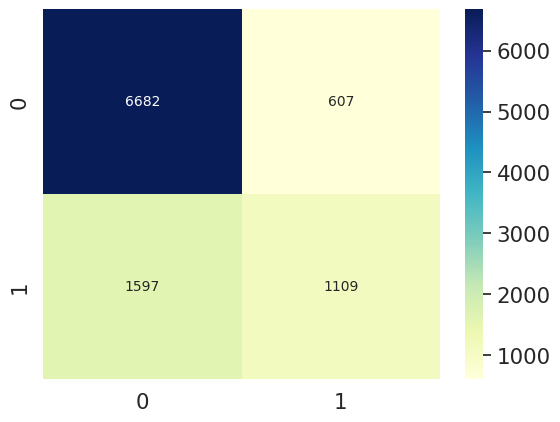

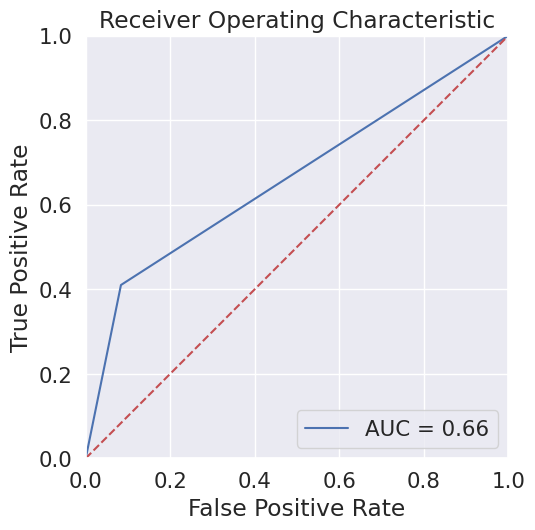

In [32]:
y_pred = model.predict(test_features)
#print the classification report to highlight the accuracy with f1-score, precision and recall

print(metrics.classification_report(test_target, y_pred))
plot_confusion_matrix(test_target, y_pred)
plot_roc_curve(test_target, y_pred)

Build the Bayes model on BERT-Model

In [ ]:
train_text_bert_numpy=train_text_bert.numpy()

test_text_bert_numpy=test_text_bert.numpy()
train_target_bert_numpy=train_target_bert.numpy()
test_text_bert_numpy

In [46]:
a1_1 = np.array(a1)
b1_1 = np.array(b1)

In [64]:
a1[0]

tensor([[  101,  2414,  1010,  ...,     0,     0,     0],
        [  101,  9733,  1012,  ...,     0,     0,     0],
        [  101,  2167,  4759,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  3003,  ...,     0,     0,     0],
        [  101,  1996,  2796,  ...,     0,     0,     0],
        [  101, 15335,  1517,  ...,     0,     0,     0]])

In [74]:
# a_train_text = [t.numpy() for t in a1]
# a_train_text
# b_train_target = [t.numpy() for t in b1]
# b_train_target
a_train_text = np.array(a1)

a_train_text = np.array([t.numpy() for t in a1])
b_train_target = np.array([t.numpy() for t in b1])
# a_train_text

In [ ]:
# from sklearn.linear_model import LogisticRegression

# # Load BERT embeddings
# train_text_bert = [get_embedding(text) for text in train_data["text"].values]
# test_text_bert = [get_embedding(text) for text in test_data["text"].values]

# # Convert target variable to numeric
# train_target_bert = train_data["sentiment"].replace({"positive": 1, "negative": 0}).values
# test_target_bert = test_data["sentiment"].replace({"positive": 1, "negative": 0}).values

# # Train logistic regression model
# model = LogisticRegression()
# model.fit(train_text_bert, train_target_bert)

# # Evaluate model
# print("Train score:", model.score(train_text_bert, train_target_bert))
# print("Test score:", model.score(test_text_bert, test_target_bert))


In [96]:
val_text_bert.shape

torch.Size([32, 542])

In [81]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_text_bert, train_target_bert)

# Evaluate model
print("Train score:", model.score(train_text_bert, train_target_bert))
print("Test score:", model.score(val_text_bert, val_target_bert))

Train score: 1.0


ValueError: ignored

In [69]:
# model = MultinomialNB() 
model.fit(a_train_text, b_train_target)
print("Train score:", model.score(a1, b1))
print("Validation score:", model.score(train_text_bert, train_target_bert))

ValueError: ignored

In [ ]:
# # test_text_bert
# test_text_bert_array = np.array(test_text_bert)  # convert the dataset to a NumPy array
# test_text_bert_array = test_text_bert_array.reshape((test_text_bert_array.shape[0], -1))  # reshape to (n_samples, n_features)
# test_text_bert_features = np.concatenate(test_text_bert_array, axis=1)  # concatenate the embeddings along axis=1


# test_text_bert_features


# test_text_bert_numpy=test_text_bert.numpy()
print("Training data shape:", train_text_bert_numpy.shape)
print("Test data shape:", test_text_bert_numpy.shape)

# select the relevant features from the test data
X_test_selected = train_text_bert_numpy[:, :test_text_bert_numpy.shape[1]]

# check that the shapes match
print("Selected test data shape:", X_test_selected.shape)
5


AttributeError: ignored

In [224]:
y_pred = model.predict(a3)
#print the classification report to highlight the accuracy with f1-score, precision and recall

print(metrics.classification_report(test_target_bert, y_pred))
plot_confusion_matrix(test_target_bert, y_pred)
plot_roc_curve(test_target_bert, y_pred)

ValueError: ignored